## Welcome to our Big Data project :  Medicare Fraud detection Tool 😃💻

We put on our big data and machine learning hats to use to solve some complex problems of real world in this project. We have used PySpark, MLLib, Scikit, Numpy.


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3938d1ac693dd961574ff97ffac0c85c1c49a860e889e4b4158fd8c53bc7ec16
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, max, min, lit
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Create a pyspark session with driver memory set to a high number to utilise Java heap space and set Garbage collector options
spark = SparkSession.builder \
    .appName("Big Data Application") \
    .config("spark.driver.memory", "15g") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
    .getOrCreate()


This is the Prescribers dataset for the year 2022(Latest) that can be downloaded from the [CMS website](https://data.cms.gov/provider-summary-by-type-of-service/medicare-part-d-prescribers/medicare-part-d-prescribers-by-provider-and-drug).

The dataset size is around 3GB and it contains useful information such as prescribing patterns and costs associated with different drugs and providers.

In [5]:
PartDRawData = "/content/drive/MyDrive/Medicare Part D Prescribers - by Provider and Drug/Medicare Part D Prescribers - by Provider and Drug/2021/MUP_DPR_RY23_P04_V10_DY21_NPIBN.csv"

In [6]:
data = spark.read.csv(PartDRawData, header=True, inferSchema=True)

In [7]:
#Let us explore the PartD Prescribers data.
columns = data.columns
print("Number of columns in the dataset : ", len(columns))
print("Columns in part D dataset : ", columns)

Number of columns in the dataset :  22
Columns in part D dataset :  ['Prscrbr_NPI', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name', 'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_State_FIPS', 'Prscrbr_Type', 'Prscrbr_Type_Src', 'Brnd_Name', 'Gnrc_Name', 'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes', 'GE65_Sprsn_Flag', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Bene_Sprsn_Flag', 'GE65_Tot_Benes']


Let us compute basic statistics (mean, median, standard deviation) for numerical columns like Tot_Clms, Tot_30day_Fills, Tot_Day_Suply, Tot_Drug_Cst, etc and visualize distributions of these key metrics to identify outliers or unusual patterns.

In [8]:
# Calculate summary statistics for numerical columns
numerical_cols = ['Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes']
stats = data.select([mean(col(c)).alias(c + '_mean') for c in numerical_cols] +
                    [stddev(col(c)).alias(c + '_stddev') for c in numerical_cols] +
                    [max(col(c)).alias(c + '_max') for c in numerical_cols] +
                    [min(col(c)).alias(c + '_min') for c in numerical_cols])

stats.show()


+------------------+--------------------+------------------+------------------+-----------------+------------------+----------------------+--------------------+-------------------+-----------------+------------+-------------------+-----------------+----------------+-------------+------------+-------------------+-----------------+----------------+-------------+
|     Tot_Clms_mean|Tot_30day_Fills_mean|Tot_Day_Suply_mean| Tot_Drug_Cst_mean|   Tot_Benes_mean|   Tot_Clms_stddev|Tot_30day_Fills_stddev|Tot_Day_Suply_stddev|Tot_Drug_Cst_stddev| Tot_Benes_stddev|Tot_Clms_max|Tot_30day_Fills_max|Tot_Day_Suply_max|Tot_Drug_Cst_max|Tot_Benes_max|Tot_Clms_min|Tot_30day_Fills_min|Tot_Day_Suply_min|Tot_Drug_Cst_min|Tot_Benes_min|
+------------------+--------------------+------------------+------------------+-----------------+------------------+----------------------+--------------------+-------------------+-----------------+------------+-------------------+-----------------+----------------+--------

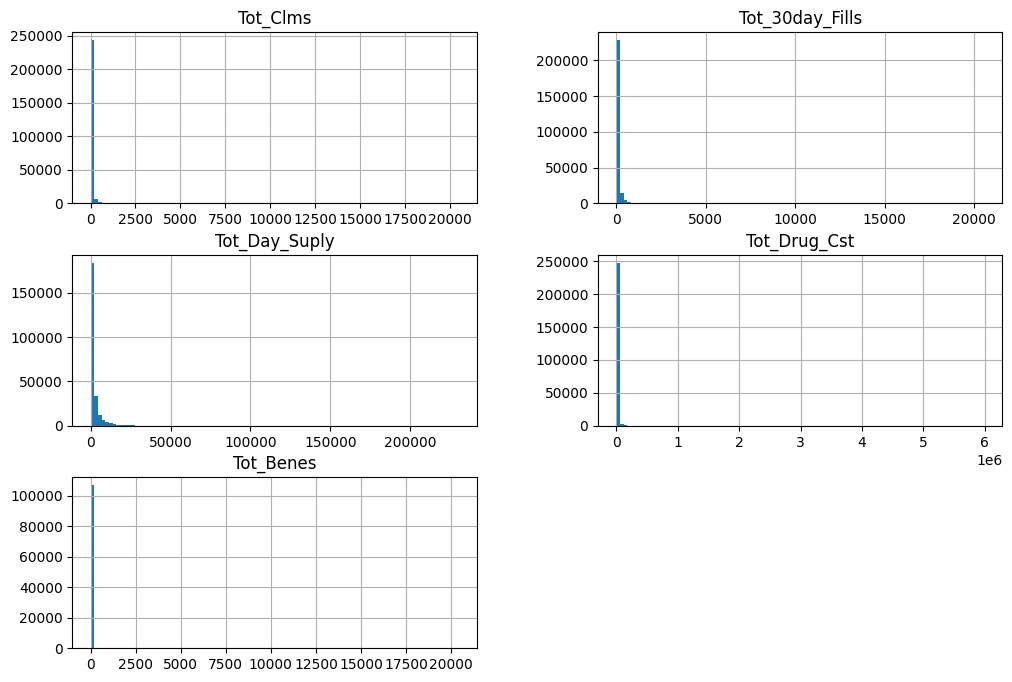

In [9]:
# Let us look at a small subset of data to visualize the Data

sampled_data = data.select(numerical_cols).sample(fraction=0.01, withReplacement=False).toPandas()

sampled_data.hist(bins=100, figsize=(12, 8))
plt.show()



We only want to retain columns that are relevant for further analysis. We will capture all numerical columns above to capture patterns in distribution. We also retain NPI, city, state, and name details to Map this dataset to other datasets later. W



In [10]:
cols_to_use = ['Prscrbr_NPI', 'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name','Prscrbr_Type', 'Tot_Drug_Cst', 'Tot_Clms', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills' ]

partDdf = data.select(cols_to_use)

In [11]:
# Print each column name and its data type
for column, dtype in partDdf.dtypes:
    print(f"Column: {column}, Type: {dtype}")

Column: Prscrbr_NPI, Type: int
Column: Prscrbr_City, Type: string
Column: Prscrbr_State_Abrvtn, Type: string
Column: Prscrbr_Last_Org_Name, Type: string
Column: Prscrbr_First_Name, Type: string
Column: Prscrbr_Type, Type: string
Column: Tot_Drug_Cst, Type: double
Column: Tot_Clms, Type: int
Column: Tot_Day_Suply, Type: int
Column: Tot_Benes, Type: int
Column: Tot_30day_Fills, Type: double


In [12]:
partDdf.show()

+-----------+------------+--------------------+---------------------+------------------+-----------------+------------+--------+-------------+---------+---------------+
|Prscrbr_NPI|Prscrbr_City|Prscrbr_State_Abrvtn|Prscrbr_Last_Org_Name|Prscrbr_First_Name|     Prscrbr_Type|Tot_Drug_Cst|Tot_Clms|Tot_Day_Suply|Tot_Benes|Tot_30day_Fills|
+-----------+------------+--------------------+---------------------+------------------+-----------------+------------+--------+-------------+---------+---------------+
| 1003000126|    Bethesda|                  MD|            Enkeshafi|           Ardalan|Internal Medicine|      125.28|      11|          930|     NULL|           31.0|
| 1003000126|    Bethesda|                  MD|            Enkeshafi|           Ardalan|Internal Medicine|      812.86|      64|         5311|       48|          177.0|
| 1003000126|    Bethesda|                  MD|            Enkeshafi|           Ardalan|Internal Medicine|      220.84|      12|         1080|     NULL|   

In [13]:
#Define all the categorical columns and extract the DF

cols_to_use =['Prscrbr_NPI','Prscrbr_City','Prscrbr_State_Abrvtn', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name', 'Prscrbr_Type', 'Gnrc_Name']
partDdf_categorical = data.select(cols_to_use)
partDdf_categorical.count()

25231862

In [14]:
#Drop duplicate values
partDdf_categorical = partDdf_categorical.dropDuplicates()
partDdf_categorical.count()

23850038

We have dropped a few duplicated in the dataset! ✌

In [15]:
#Simplify the column names for joining later with other datasets
partDdf_categorical = partDdf_categorical.withColumnRenamed("Prscrbr_First_Name","first_name")\
                   .withColumnRenamed("Prscrbr_Last_Org_Name","last_name")\
                   .withColumnRenamed("Prscrbr_City","city")\
                   .withColumnRenamed("Prscrbr_State_Abrvtn","state")\
                   .withColumnRenamed("Prscrbr_Type","speciality")


In [16]:
# Group columns on NPI and get aggregate results.
group_cols = ['Prscrbr_NPI']

agg_dict = {
    'Tot_Drug_Cst': [F.sum('Tot_Drug_Cst').alias('sum_Tot_Drug_Cst'),
                     F.mean('Tot_Drug_Cst').alias('mean_Tot_Drug_Cst'),
                     F.max('Tot_Drug_Cst').alias('max_Tot_Drug_Cst')],
    'Tot_Clms': [F.sum('Tot_Clms').alias('sum_Tot_Clms'),
                 F.mean('Tot_Clms').alias('mean_Tot_Clms'),
                 F.max('Tot_Clms').alias('max_Tot_Clms')],
    'Tot_Day_Suply': [F.sum('Tot_Day_Suply').alias('sum_Tot_Day_Suply'),
                      F.mean('Tot_Day_Suply').alias('mean_Tot_Day_Suply'),
                      F.max('Tot_Day_Suply').alias('max_Tot_Day_Suply')],
    'Tot_Benes': [F.sum('Tot_Benes').alias('sum_Tot_benes'),
                      F.mean('Tot_Benes').alias('mean_Tot_benes'),
                      F.max('Tot_Benes').alias('max_Tot_benes')],
    'Tot_30day_Fills': [F.sum('Tot_30day_Fills').alias('sum_Tot_30day_Fills'),
                      F.mean('Tot_30day_Fills').alias('mean_Tot_30day_Fills'),
                      F.max('Tot_30day_Fills').alias('max_Tot_30day_Fills')]
}

# Perform the grouping and aggregation
partDdf_numeric = data.groupBy(group_cols).agg(*[item for sublist in agg_dict.values() for item in sublist])

In [17]:
partDdf_numeric = partDdf_numeric.withColumnRenamed("sum_Tot_Drug_Cst", "Drug_Cost_Sum")\
                             .withColumnRenamed("mean_Tot_Drug_Cst", "Drug_Cost_Mean")\
                             .withColumnRenamed("max_Tot_Drug_Cst", "Drug_Cost_Max")\
                             .withColumnRenamed("sum_Tot_Clms", "Claims_Sum")\
                             .withColumnRenamed("mean_Tot_Clms", "Claims_Mean")\
                             .withColumnRenamed("max_Tot_Clms", "Claims_Max")\
                             .withColumnRenamed("sum_Tot_Day_Suply", "Day_Supply_Sum")\
                             .withColumnRenamed("mean_Tot_Day_Suply", "Day_Supply_Mean")\
                             .withColumnRenamed("max_Tot_Day_Suply", "Day_Supply_Max")\
                             .withColumnRenamed("sum_Tot_benes", "Benefeciaries_Sum")\
                             .withColumnRenamed("mean_Tot_benes", "Benefeciaries_Mean")\
                             .withColumnRenamed("max_Tot_benes", "Benefeciaries_Max")\
                             .withColumnRenamed("sum_Tot_30day_Fills", "30Day_fill_Sum")\
                             .withColumnRenamed("mean_Tot_30day_Fills", "30Day_fill_Mean")\
                             .withColumnRenamed("max_Tot_30day_Fills", "30Day_fill_Max")



In [18]:
# Display the DataFrame to verify the new column names
partDdf_numeric.show()

+-----------+------------------+------------------+-------------+----------+------------------+----------+--------------+------------------+--------------+-----------------+------------------+-----------------+------------------+------------------+--------------+
|Prscrbr_NPI|     Drug_Cost_Sum|    Drug_Cost_Mean|Drug_Cost_Max|Claims_Sum|       Claims_Mean|Claims_Max|Day_Supply_Sum|   Day_Supply_Mean|Day_Supply_Max|Benefeciaries_Sum|Benefeciaries_Mean|Benefeciaries_Max|    30Day_fill_Sum|   30Day_fill_Mean|30Day_fill_Max|
+-----------+------------------+------------------+-------------+----------+------------------+----------+--------------+------------------+--------------+-----------------+------------------+-----------------+------------------+------------------+--------------+
| 1003043209|18613.119999999995| 930.6559999999997|      7077.18|       355|             17.75|        44|         21040|            1052.0|          3000|               49|16.333333333333332|               2

Now let's join the categorical columns with updated names with the numeric aggregated value calculated above. 🍳

In [19]:
#Join the two subsets of the same dataset after data manipulation.

partD_data = partDdf_categorical.join(partDdf_numeric, on='Prscrbr_NPI', how='left')

In [20]:
#Get the number again, should be the same as before! ie, 23850038
partD_data.count()


23850038

In [21]:
# Since we donot want dataset to have incorrect data, we will just drop the rows with null values .
partD_data = partD_data.dropna(how='any')

In [22]:
#23228055 Vs 23850038
# Get the count now after cleaning the dataset
partD_data.count()

23228055

We have dropped about 621,983, which is not significant compared to the total number of rows we have.



----------







### Now we move on to our second dateset exploration!

The most common dataset for geteting medical information other than CMS is  openpaymentsdata.cms.go. We downlaoded the data from [here](https://www.cms.gov/priorities/key-initiatives/open-payments/data/dataset-downloads). We used the latest dataset that is for the year 2022.

Each record includes the physician’s demographic information, specialties, and license information, as well as a unique identification number (Physician Profile ID) that can be used to search for a specific physician. We map this dataset to our first dataset to create a more informative set! 💡

In [23]:
OpenPaymentData = "/content/drive/MyDrive/OP_DTL_GNRL_PGYR2022_P01182024.csv"

In [24]:
data = spark.read.csv(OpenPaymentData, header=True, inferSchema=True)

In [25]:
#Let us explore the Open payment dataset.
columns = data.columns
print("Number of columns in the dataset : ", len(columns))
print("Columns in part D dataset : ", columns)

Number of columns in the dataset :  91
Columns in part D dataset :  ['Change_Type', 'Covered_Recipient_Type', 'Teaching_Hospital_CCN', 'Teaching_Hospital_ID', 'Teaching_Hospital_Name', 'Covered_Recipient_Profile_ID', 'Covered_Recipient_NPI', 'Covered_Recipient_First_Name', 'Covered_Recipient_Middle_Name', 'Covered_Recipient_Last_Name', 'Covered_Recipient_Name_Suffix', 'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City', 'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country', 'Recipient_Province', 'Recipient_Postal_Code', 'Covered_Recipient_Primary_Type_1', 'Covered_Recipient_Primary_Type_2', 'Covered_Recipient_Primary_Type_3', 'Covered_Recipient_Primary_Type_4', 'Covered_Recipient_Primary_Type_5', 'Covered_Recipient_Primary_Type_6', 'Covered_Recipient_Specialty_1', 'Covered_Recipient_Specialty_2', 'Covered_Recipient_Specialty_3', 'Covered_Recipient_Specialty_4', 'Covered_Recipient_Specialty_5', 'Covered_Recipient_

There are 91 columns in this dataset! We need to find columns that can help integrate numerical pattern to dataset 1. We can map the datasets using NPI which is a unique identifier here.

In [26]:
cols_to_use = ['Covered_Recipient_NPI', 'Total_Amount_of_Payment_USDollars', 'Number_of_Payments_Included_in_Total_Amount']
paymentDf = data.select(cols_to_use)

In [27]:
paymentDf.count()

13151823

In [28]:
# Group by 'Covered_Recipient_NPI' and aggregate sums of payment amounts and counts of payments
paymentdf = paymentDf.groupBy('Covered_Recipient_NPI').agg(
    F.sum('Total_Amount_of_Payment_USDollars').alias('Total_Payment_Sum'),
    F.sum('Number_of_Payments_Included_in_Total_Amount').alias('Total_Payment_Count')
)

# Cast the aggregated sums to float and counts to integer
paymentdf = paymentdf.withColumn("Total_Payment_Sum", F.col("Total_Payment_Sum").cast("float")) \
                         .withColumn("Total_Payment_Count", F.col("Total_Payment_Count").cast("integer"))

# Show the results to verify
paymentdf.show()

+---------------------+-----------------+-------------------+
|Covered_Recipient_NPI|Total_Payment_Sum|Total_Payment_Count|
+---------------------+-----------------+-------------------+
|           1235238858|          1501.56|                  5|
|           1417180837|           150.21|                  9|
|           1649431024|          2594.16|                120|
|           1235611005|           762.39|                 34|
|           1487602066|            18.82|                  1|
|           1043470685|          3418.52|                 11|
|           1780070235|          3736.17|                 65|
|           1114921079|          1149.62|                 90|
|           1265492417|           289.93|                 11|
|           1982955878|            30.79|                  2|
|           1629621792|            12.44|                  1|
|           1174687412|            14.49|                  1|
|           1578095014|          2818.58|                  6|
|       

In [29]:
#Let us try to visualize the data a bit!

# Sampling approximately 1% of the data
sampled_data = paymentDf.sample(False, 0.01)
sampled_data_pd = sampled_data.toPandas()


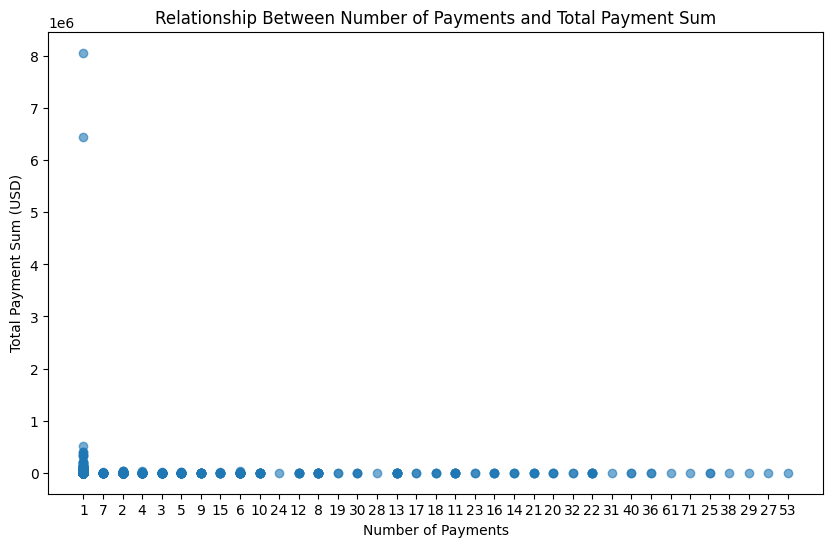

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(sampled_data_pd['Number_of_Payments_Included_in_Total_Amount'], sampled_data_pd['Total_Amount_of_Payment_USDollars'], alpha=0.6)
plt.title('Relationship Between Number of Payments and Total Payment Sum')
plt.xlabel('Number of Payments')
plt.ylabel('Total Payment Sum (USD)')
plt.show()


We can spot a few anamolous points, which can be inferred from the fact that they deviate from the general pattern. Most of them reperesenting large payments in single transaction. 💰

In [31]:
# rename the column NPI to map it to dataset 1
paymentdf = paymentdf.withColumnRenamed('Covered_Recipient_NPI', 'Prscrbr_NPI')

In [32]:
# Joining partdDF and paymentdf on 'Prscrbr_NPI'
joined_df = partD_data.join(paymentdf, ['Prscrbr_NPI'], 'left')

# Replace null values with 0 in the resulting DataFrame
joined_df = joined_df.fillna(0)


In [33]:
joined_df.show()

+-----------+---------+-----+---------+----------+--------------------+--------------------+-------------+------------------+-------------+----------+-----------------+----------+--------------+------------------+--------------+-----------------+------------------+-----------------+--------------+------------------+--------------+-----------------+-------------------+
|Prscrbr_NPI|     city|state|last_name|first_name|          speciality|           Gnrc_Name|Drug_Cost_Sum|    Drug_Cost_Mean|Drug_Cost_Max|Claims_Sum|      Claims_Mean|Claims_Max|Day_Supply_Sum|   Day_Supply_Mean|Day_Supply_Max|Benefeciaries_Sum|Benefeciaries_Mean|Benefeciaries_Max|30Day_fill_Sum|   30Day_fill_Mean|30Day_fill_Max|Total_Payment_Sum|Total_Payment_Count|
+-----------+---------+-----+---------+----------+--------------------+--------------------+-------------+------------------+-------------+----------+-----------------+----------+--------------+------------------+--------------+-----------------+------------

In [34]:
joined_df.count()

23228055

In [35]:
joined_df

DataFrame[Prscrbr_NPI: int, city: string, state: string, last_name: string, first_name: string, speciality: string, Gnrc_Name: string, Drug_Cost_Sum: double, Drug_Cost_Mean: double, Drug_Cost_Max: double, Claims_Sum: bigint, Claims_Mean: double, Claims_Max: int, Day_Supply_Sum: bigint, Day_Supply_Mean: double, Day_Supply_Max: int, Benefeciaries_Sum: bigint, Benefeciaries_Mean: double, Benefeciaries_Max: int, 30Day_fill_Sum: double, 30Day_fill_Mean: double, 30Day_fill_Max: double, Total_Payment_Sum: float, Total_Payment_Count: int]



---


### Now comes the 3rd dataset, which is the most important aspect of our analysis, i.e, Labeling our data! ⚡

We get the latest dataset from [OIG Exclusion dataset](https://oig.hhs.gov/exclusions/exclusions_list.asp) which gives us the latest exlusiion list of all practioners. We use this to mark our data as fraud/ not fraud in the existing merged database. Let's get started!

In [36]:
LEIEdataset = "/content/drive/MyDrive/LEIE.csv"
data = spark.read.csv(LEIEdataset, header=True, inferSchema=True)

In [37]:
#Let us explore the LEIE dataset.
columns = data.columns
print("Number of columns in the dataset : ", len(columns))
print("Columns in part D dataset : ", columns)

Number of columns in the dataset :  18
Columns in part D dataset :  ['LASTNAME', 'FIRSTNAME', 'MIDNAME', 'BUSNAME', 'GENERAL', 'SPECIALTY', 'UPIN', 'NPI', 'DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'EXCLTYPE', 'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE']


There are columns. We use the EXCLTYPE to label data here as "label" column where 1 represents FRAUD ❌ and 0 represents not fraud ✅

In [38]:
cols_to_use = ['NPI', 'EXCLTYPE']

LEIEdf= data.select(cols_to_use)

In [39]:
#remove rows with NPI value as 0, NPI is generally a 10 digit number
LEIEdf = LEIEdf.filter("NPI != 0")

In [40]:
#print total number of rows
LEIEdf.count()

7328

In [41]:
LEIEdf = LEIEdf.withColumnRenamed("NPI", "Prscrbr_NPI")\
               .withColumnRenamed("EXCLTYPE", "label")

# Show the DataFrame schema to verify the new column names
LEIEdf.printSchema()

root
 |-- Prscrbr_NPI: integer (nullable = true)
 |-- label: string (nullable = true)



In [42]:
# Set 'label' to 1 for all rows (indicating exclusion/fraud)
LEIEdf = LEIEdf.withColumn("label", lit(1))


In [43]:
joined_df

DataFrame[Prscrbr_NPI: int, city: string, state: string, last_name: string, first_name: string, speciality: string, Gnrc_Name: string, Drug_Cost_Sum: double, Drug_Cost_Mean: double, Drug_Cost_Max: double, Claims_Sum: bigint, Claims_Mean: double, Claims_Max: int, Day_Supply_Sum: bigint, Day_Supply_Mean: double, Day_Supply_Max: int, Benefeciaries_Sum: bigint, Benefeciaries_Mean: double, Benefeciaries_Max: int, 30Day_fill_Sum: double, 30Day_fill_Mean: double, 30Day_fill_Max: double, Total_Payment_Sum: float, Total_Payment_Count: int]

Now we join the merged DF (dataset1 + dataset 2) with dataset 3! YAY 😀

In [44]:
# Features Engineering
Features_df = joined_df.join(LEIEdf, ['Prscrbr_NPI'], 'left')

In [45]:
Features_df

DataFrame[Prscrbr_NPI: int, city: string, state: string, last_name: string, first_name: string, speciality: string, Gnrc_Name: string, Drug_Cost_Sum: double, Drug_Cost_Mean: double, Drug_Cost_Max: double, Claims_Sum: bigint, Claims_Mean: double, Claims_Max: int, Day_Supply_Sum: bigint, Day_Supply_Mean: double, Day_Supply_Max: int, Benefeciaries_Sum: bigint, Benefeciaries_Mean: double, Benefeciaries_Max: int, 30Day_fill_Sum: double, 30Day_fill_Mean: double, 30Day_fill_Max: double, Total_Payment_Sum: float, Total_Payment_Count: int, label: int]

Let us utilise some Pyspark features now, we will describe the df using statistical function describe()

In [46]:
statistics_df = Features_df.describe()
statistics_df.show()

+-------+--------------------+-----------------+--------+-----------+-------------+----------------+--------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----+
|summary|         Prscrbr_NPI|             city|   state|  last_name|   first_name|      speciality|           Gnrc_Name|      Drug_Cost_Sum|    Drug_Cost_Mean|     Drug_Cost_Max|       Claims_Sum|      Claims_Mean|       Claims_Max|    Day_Supply_Sum|   Day_Supply_Mean|    Day_Supply_Max| Benefeciaries_Sum|Benefeciaries_Mean| Benefeciaries_Max|    30Day_fill_Sum|   30Day_fill_Mean|   30Day_fill_Max| Total_Payment_Sum|Total_Payment_Count|label|
+-------+--------------------+-----------------+--------+-----------+-------------+----------------+--

In [47]:
# Fill missing values with 0
Features_df = Features_df.fillna(0)

In [48]:
fraud_data = Features_df.filter(Features_df.label == 1)
normal_data = Features_df.filter(Features_df.label != 1)

In [49]:
from pyspark.sql.functions import rand

sampled_data = normal_data.orderBy(rand()).limit(200000)

In [50]:
combined_data = sampled_data.union(fraud_data)
final_data = combined_data.orderBy(rand())
#final_data = final_data.repartition(5000)


In [51]:
#sampled_data.count()

In [52]:
#pandas_df = final_data.toPandas()

In [53]:
from pyspark.sql.functions import col, log10


# Applying log10 scaling and creating new features using the correct column names
final_data = final_data.withColumn("Drug_Cost_Sum", log10(col("Drug_Cost_Sum") + 1.0))\
                               .withColumn("Claims_Sum", log10(col("Claims_Sum") + 1.0))\
                               .withColumn("Day_Supply_Sum", log10(col("Day_Supply_Sum") + 1.0))\
                               .withColumn("Total_Payment_Sum", log10(col("Total_Payment_Sum") + 1.0))\
                               .withColumn("Total_Payment_Count", log10(col("Total_Payment_Count") + 1.0))\
                               .withColumn("Drug_Cost_Mean", log10(col("Drug_Cost_Mean") + 1.0))\
                               .withColumn("Claims_Mean", log10(col("Claims_Mean") + 1.0))\
                               .withColumn("Day_Supply_Mean", log10(col("Day_Supply_Mean") + 1.0))\
                               .withColumn("Drug_Cost_Max", log10(col("Drug_Cost_Max") + 1.0))\
                               .withColumn("Claims_Max", log10(col("Claims_Max") + 1.0))\
                               .withColumn("Day_Supply_Max", log10(col("Day_Supply_Max") + 1.0))\
                               .withColumn("claim_max-mean", col("Claims_Max") - col("Claims_Mean"))\
                               .withColumn("supply_max-mean", col("Day_Supply_Max") - col("Day_Supply_Mean"))\
                               .withColumn("drug_max-mean", col("Drug_Cost_Max") - col("Drug_Cost_Mean"))\
                               .withColumn("Benefeciaries_Sum", log10(col("Benefeciaries_Sum") + 1.0))\
                               .withColumn("Benefeciaries_Mean", log10(col("Benefeciaries_Mean") + 1.0))\
                               .withColumn("Benefeciaries_Max", log10(col("Benefeciaries_Max") + 1.0))\
                               .withColumn("Benefeciaries_max-mean", col("Benefeciaries_Max") - col("Benefeciaries_Mean"))\
                               .withColumn("30Day_fill_Sum", log10(col("30Day_fill_Sum") + 1.0))\
                               .withColumn("30Day_fill_Mean", log10(col("30Day_fill_Mean") + 1.0))\
                               .withColumn("30Day_fill_Max", log10(col("30Day_fill_Max") + 1.0))\
                               .withColumn("30Day_fill_max-mean", col("30Day_fill_Max") - col("30Day_fill_Mean"))\



In [54]:
final_data

DataFrame[Prscrbr_NPI: int, city: string, state: string, last_name: string, first_name: string, speciality: string, Gnrc_Name: string, Drug_Cost_Sum: double, Drug_Cost_Mean: double, Drug_Cost_Max: double, Claims_Sum: double, Claims_Mean: double, Claims_Max: double, Day_Supply_Sum: double, Day_Supply_Mean: double, Day_Supply_Max: double, Benefeciaries_Sum: double, Benefeciaries_Mean: double, Benefeciaries_Max: double, 30Day_fill_Sum: double, 30Day_fill_Mean: double, 30Day_fill_Max: double, Total_Payment_Sum: double, Total_Payment_Count: double, label: int, claim_max-mean: double, supply_max-mean: double, drug_max-mean: double, Benefeciaries_max-mean: double, 30Day_fill_max-mean: double]

In [55]:
pandas_df = final_data.toPandas()


In [56]:
#pandas_df

In [57]:
total_memory = pandas_df.memory_usage(deep=True).sum()
print("Total memory usage (in bytes):", total_memory)

Total memory usage (in bytes): 122812063


### Time to test the data on some great Models! 💃

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [59]:
# Identify categorical columns (excluding target)
categorical_cols = ['city', 'state', 'last_name', 'first_name', 'speciality']

# Numerical columns
numerical_cols = ['Drug_Cost_Sum', 'Drug_Cost_Mean', 'Drug_Cost_Max', 'drug_max-mean',
                  'Claims_Sum', 'Claims_Mean', 'Claims_Max', 'claim_max-mean',
                  'Day_Supply_Sum', 'Day_Supply_Mean', 'Day_Supply_Max', 'supply_max-mean',
                  'Benefeciaries_Sum', 'Benefeciaries_Mean', 'Benefeciaries_Max', 'Benefeciaries_max-mean',
                  '30Day_fill_Sum', '30Day_fill_Mean', '30Day_fill_Max', '30Day_fill_max-mean',
                  'Total_Payment_Sum', 'Total_Payment_Count']



In [60]:
# Features and target
X = pandas_df.drop('label', axis=1)
y = pandas_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [61]:
# Define the imputer
numerical_imputer = SimpleImputer(strategy='mean')  # Replace NaN with the mean of the column

# Update the numerical transformer to include scaling and imputing
numerical_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', StandardScaler())
])

# Categorical data preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace NaN with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to apply transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a complete pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


# Train the model
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9999763184692259




1.   Let us try Random Forest



In [ ]:
# Create a complete pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


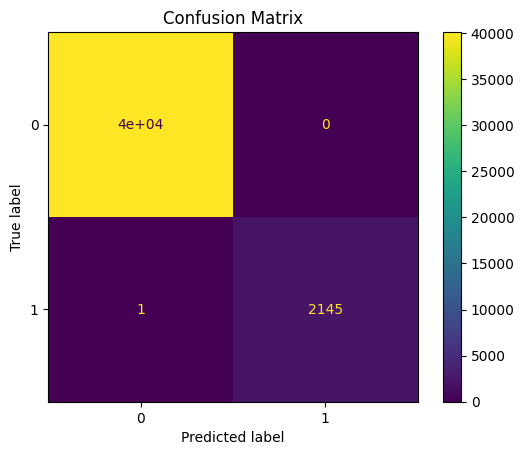

In [62]:
# Generate predictions
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


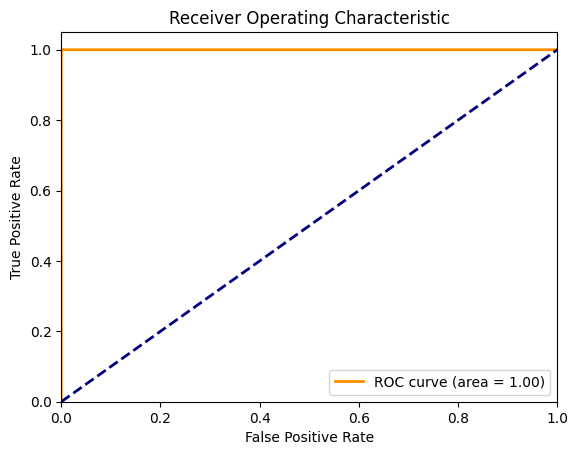

In [63]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [64]:
# 1. Logistic Regression
# 2. Random Forest
# 3. Gradient Boosted Trees
# Data visualization  - Library: Matplotlib
# TEST dask df

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Update the model in the pipeline
model_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_lr))
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))


Accuracy (Logistic Regression): 0.9968977194685864
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40081
           1       0.94      1.00      0.97      2146

    accuracy                           1.00     42227
   macro avg       0.97      1.00      0.98     42227
weighted avg       1.00      1.00      1.00     42227



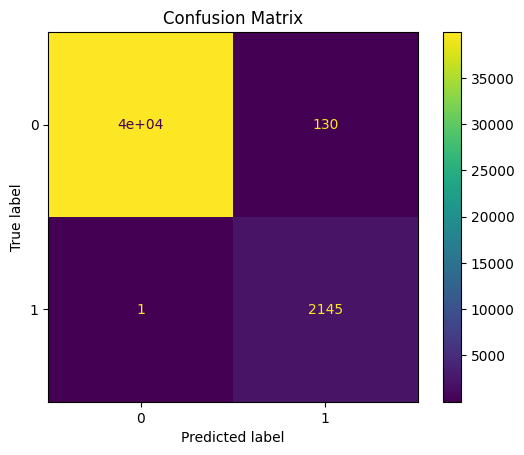

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


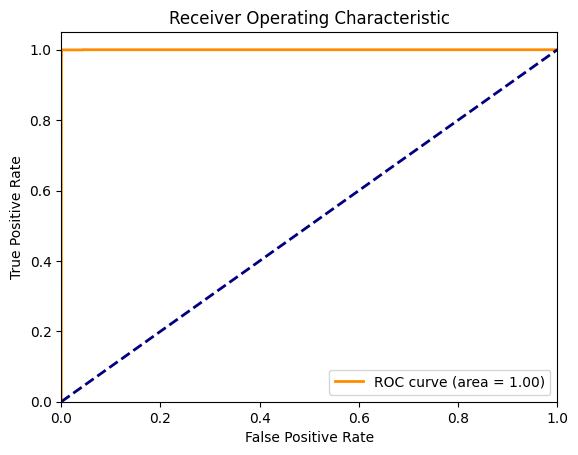

In [69]:

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Linear Regsression')
plt.legend(loc="lower right")
plt.show()


In [71]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a pipeline with preprocessing and Gradient Boosting classifier
model_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

# Train the model
model_gbm.fit(X_train, y_train)

# Make predictions
y_pred_gbm = model_gbm.predict(X_test)

# Evaluate the model
print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gbm))
print("Classification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gbm))


Accuracy (Gradient Boosting): 0.9690719208089611
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     40081
           1       1.00      0.39      0.56      2146

    accuracy                           0.97     42227
   macro avg       0.98      0.70      0.77     42227
weighted avg       0.97      0.97      0.96     42227



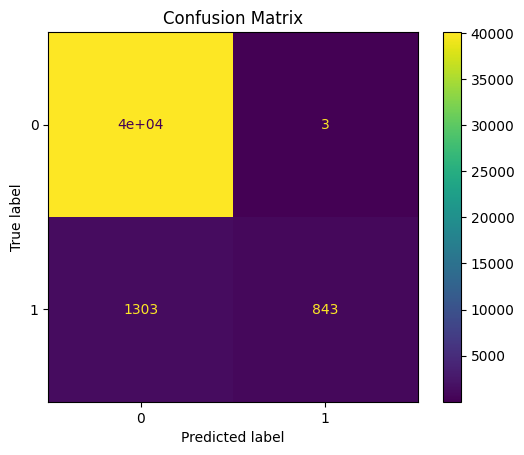

In [72]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_gbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


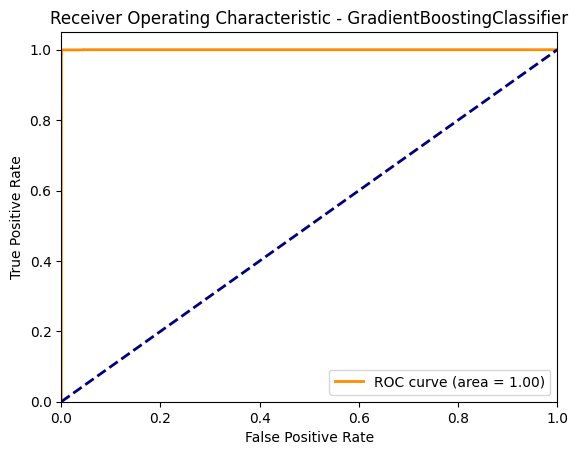

In [73]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - GradientBoostingClassifier')
plt.legend(loc="lower right")
plt.show()
